# Main wrapper for pedigree simulation & IBD matrix generation

run on cluster

In [1]:
import numpy as np
import os as os
import sys as sys
import multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py as h5py
from scipy import interpolate
from scipy import stats
import random
import itertools
import logging
import time
from itertools import product
from matplotlib.backends.backend_pdf import PdfPages
import datetime

# Disable matplotlib warnings
logger = logging.getLogger('matplotlib')
logger.setLevel(logging.ERROR)

# Set correct font type for image saving
from matplotlib import rcParams  
rcParams['font.family'] = 'sans-serif'  
rcParams['font.sans-serif'] = ['Arial'] 
rcParams['font.size'] = 15
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

# Show the current working directory
print(os.getcwd()) 
os.chdir('./ped-sim')

print(f"CPU Count: {mp.cpu_count()}")
total_memory = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')
print(f"Total Physical Memory: {total_memory/(10**9):.2f} GB")

/home/marcus/Project/BLG_analysis/kinship_structure
CPU Count: 12
Total Physical Memory: 18.86 GB


### Generate def file for large family & run pedsim

In [2]:
from generate_pop_def import generate_def, get_lineage_populations, calculate_lengths

def run_pedsim(par_file="par/ibd/gp1.def",
               output="output/ibd/gp1",
               gmap="refined_mf.simmap",
               o_file="output/ibd/gp1",
               i_file="interfere/nu_p_campbell.tsv"):
    """Wrapper to run pedsim"""
    
    os.makedirs('./outputs', exist_ok=True)
    !./ped-sim -d $par_file -m $gmap -o $output --intf $i_file --fam


### sanity check: generate a 6-generation family and run pedsim
def_text = generate_def(name = '6gen_test',size = (50,100), generations = 6, outsider_rate = 0.3, rule = 'patrilineal', compensate_outsider=False, mean_children=2)
lin, pop, cen = get_lineage_populations(def_text)
max_num, total_num = calculate_lengths(lin)

print(def_text)
print(f'Calculated centrality: {cen:.3f}, Actual centrality: {max_num/total_num :.3f}\n')
assert cen == max_num/total_num

run_pedsim(par_file='./defs/6gen_test.def', output="./outputs/6gen_test")

generated patrilineal family tree with 99 valid individuals
def 6gen_test0 1 6 M
1 1 1
2 1 1 1,:1 
3 1 7 1-4,:1 5-7: 
4 1 7 1,:2 7:3 2,:5 3,:6 4,:7 5-6: 
5 1 24 1-4,:1 5-9,:2 10-11,23:3 12-18,:4 19-20,24:5 21-22: 
6 1 43 1-3,38-40:1 4-8,:3 9,:4 10-11,:5 12,41:8 13-14,:11 15-19,42:12 20-23,:15 43:16 24-25,:17 26,:20 27-31,:21 32-37: 38sF 40sF 41sF 

Calculated centrality: 0.323, Actual centrality: 0.323

Pedigree simulator!  v1.4.5    (Released 13 Dec 2024)

  Def file:		./defs/6gen_test.def
  Map file:		refined_mf.simmap
  Input VCF:		[none: no genetic data]
  Output prefix:	./outputs/6gen_test

  Random seed:		4125175808

  Interference file:	interfere/nu_p_campbell.tsv

Simulating haplotype transmissions... done.
Printing IBD segments... done.
Printing fam file... done.  (Do not use with PLINK data: see README.md)

To simulate genetic data, must use an input VCF with 32 founders.


### Processing functions for simulated/real IBD results
randomly sampling individuals, rearrange IBD tables, generating IBD matrices and calculating matrix similarities

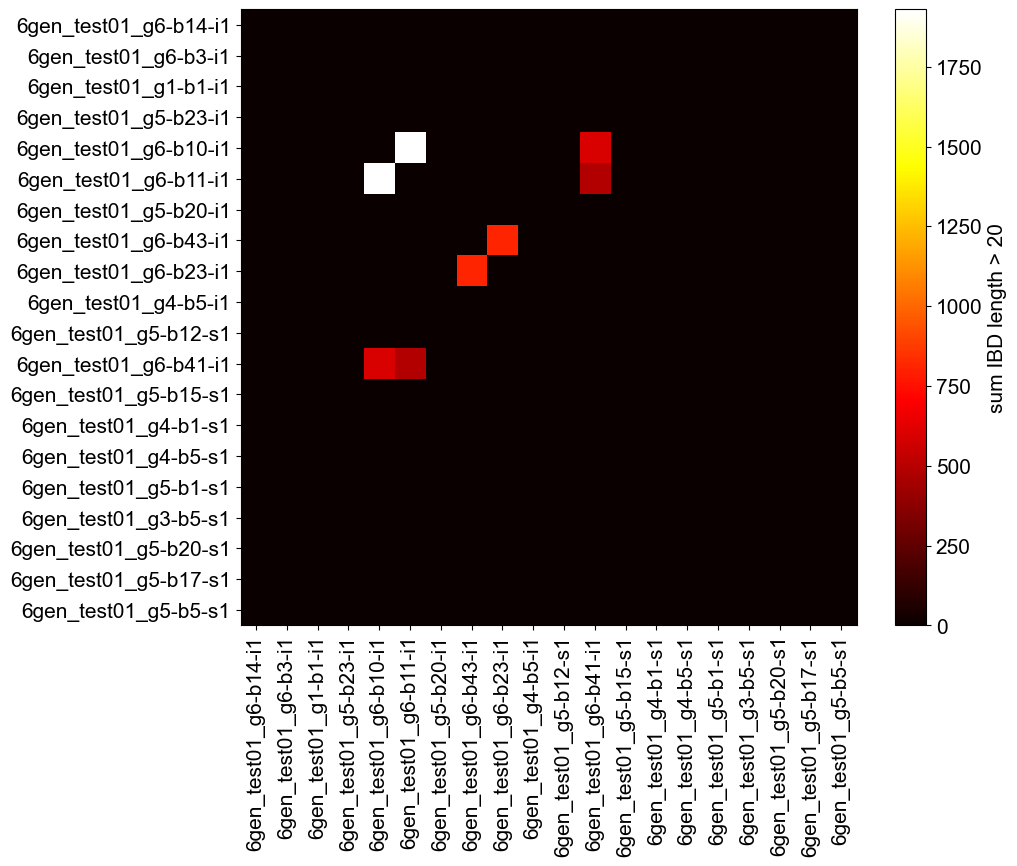

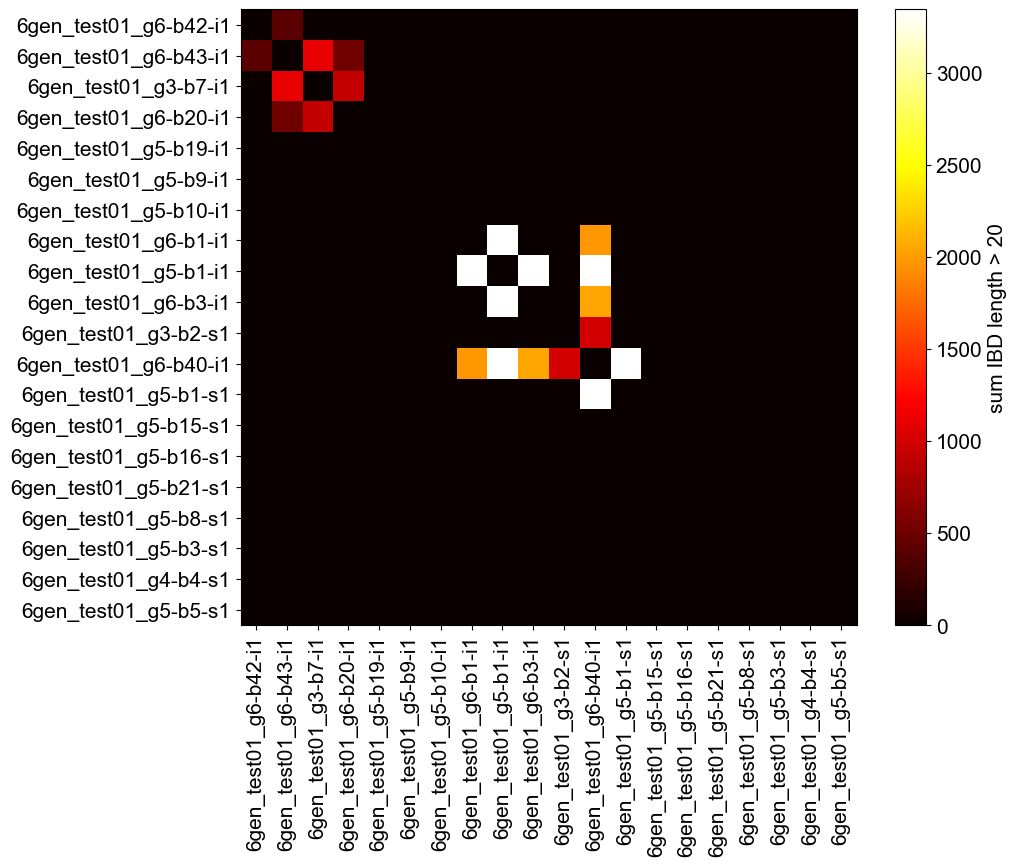

matrix_similarity(fro): 0.232


In [3]:
from seg_process import sample_individuals_mf, generate_mt_df
from ancIBD_funcs import to_hapsburg_ibd_df
from seg_process import generate_matrix, matrix_simmilarity

# sanity check: randomly sample 10 male + 10 female from previous ped-sim results for 2 times, then summary their IBD matrices

fam_info = pd.read_csv("./outputs/6gen_test-everyone.fam", sep=" ", header=None)
fam_info = generate_mt_df(fam_info)

matrices = []
for j in range(2):
    _,individuals,_ = sample_individuals_mf("./outputs/6gen_test.seg", male_sample_num = 10,female_sample_num = 10, sex_ref = fam_info, suffix = f'_sample_{j}')
    individ_pairs = list(itertools.combinations(individuals, 2))
    new_df = pd.DataFrame([{'iid1': combo[0], 'iid2': combo[1]} for combo in individ_pairs])
    
    df_test = to_hapsburg_ibd_df(path_segments = f"./outputs/6gen_test_sample_{j}.seg")
    merged_df = df_test.merge(new_df, on=['iid1', 'iid2'],how = 'right')
    merged_df.fillna(0, inplace=True)
    IBD_matrix = generate_matrix(merged_df, fam_info, keep_sex = True, plot = True, clustering=True)
    matrices.append(IBD_matrix)

print(f'matrix_similarity(fro): {matrix_simmilarity(matrices[0], matrices[1], method = "fro"):.3f}')
    

### Main Simulation
#### With automatic statistics

In [4]:
from scipy import stats
import datetime


# wrapper for one simulation
# this version returns all simulated IBD matrices


def run_simulations_statmat_new(out_folder = './outputs/', tree_rep = 40, samp_rep = 50, male_samp_num = 35, female_samp_num = 10, ref_data = None, use_mt = False,
                    size = (100,150), generations = 7, mean_children = 2, outsider_rate = 0, rule = 'patrilineal', purity = 1, die_rate = 0.2,compensate = False,
                    founder_num = 1, matrix_order = 'orig', clustering = False, centrality_requirement = None):
   
    timestamp = datetime.datetime.now().strftime(f"%Y_%m_%d_%H_%M_%S")
    pid = str(random.random())[2:]
    
    the_out_folder = f'{out_folder}{timestamp}_{pid}/'
    os.mkdir(the_out_folder)
    
    similarity_all = np.zeros((samp_rep, tree_rep))
    matrix_all = np.zeros((male_samp_num+female_samp_num, male_samp_num+female_samp_num,samp_rep,tree_rep))
    trees_all = np.full((tree_rep,), '', dtype=np.dtype('U1024')) 
    centralities = np.ones((tree_rep,))
    
    for fam_num in range(tree_rep):
        rule = rule
        basename = f'{timestamp}_{pid}_{generations}gen_{size[1]}size_{rule}_{outsider_rate}out_{purity}pur{fam_num}'
        
        flag = 0
        while flag == 0:
            def_text = generate_def(name = basename, rule = rule, size = size, generations = generations, mean_children = mean_children,
                        outsider_rate = outsider_rate, purity = purity, die_rate = die_rate, compensate_outsider=compensate,
                                    founder_num = founder_num,centrality_requirement = centrality_requirement)
            
            run_pedsim(par_file=f'./defs/'+basename+'.def', output=f"{the_out_folder}{basename}")
            print(f"{the_out_folder}{basename}")
            fam_info = pd.read_csv(f'{the_out_folder}{basename}-everyone.fam', sep=" ", header=None)
            fam_info = generate_mt_df(fam_info)
            try:
                _,_,flag = sample_individuals_mf(f"{the_out_folder}{basename}.seg", male_sample_num = male_samp_num,female_sample_num = female_samp_num,
                                                sex_ref = fam_info, save = False)
                print(flag)
            except:
                print('sample failed! retrying')
                continue
        
        # savepath = "./outputs/ancIBD_tsv/test_ped_10gen"
        
        for j in range(samp_rep):
            _, individuals, _ = sample_individuals_mf(f"{the_out_folder}{basename}.seg", male_sample_num = male_samp_num,female_sample_num = female_samp_num,
                                                sex_ref = fam_info, suffix = f'_sample_{j}')
            individ_pairs = list(itertools.combinations(individuals, 2))
            new_df = pd.DataFrame([{'iid1': combo[0], 'iid2': combo[1]} for combo in individ_pairs])
            
            try:
                df_test = to_hapsburg_ibd_df(path_segments = f"{the_out_folder}{basename}_sample_{j}.seg", n=500)
            except:
                df_test = pd.DataFrame(columns = ['iid1','iid2','sum_IBD>20','n_IBD>20'])
            
            merged_df = df_test.merge(new_df, on=['iid1', 'iid2'],how = 'right')
            merged_df.fillna(0, inplace=True)
            
            mt_ref = fam_info if use_mt else None
            IBD_matrix = generate_matrix(merged_df, fam_info, mt_ref=mt_ref, order = matrix_order, keep_sex = True, plot = False, clustering=clustering)
            matrix_all[:,:,j,fam_num] = IBD_matrix
            
            # similarity = matrix_simmilarity(IBD_matrix, ref_data, method = 'pearson')
            similarity = matrix_simmilarity(IBD_matrix, ref_data)
            
            similarity_all[j,fam_num] = similarity
            
            os.remove(f"{the_out_folder}{basename}_sample_{j}.seg")
        
        os.remove(f"{the_out_folder}{basename}.seg") 
        trees_all[fam_num] = f"{the_out_folder}{basename}-everyone.fam"
        _,_,centrality = get_lineage_populations(def_text)
        centralities[fam_num] = centrality
        
    similarity_by_tree = np.mean(similarity_all, axis = 0)
    max_tree = trees_all[np.argmax(similarity_by_tree)]
    
    sorted_indices = np.argsort(similarity_by_tree)
    median_index = len(sorted_indices) // 2
    median_tree = trees_all[sorted_indices[median_index]]

    return similarity_all, matrix_all, trees_all, max_tree, median_tree, centralities


### Read BLG data

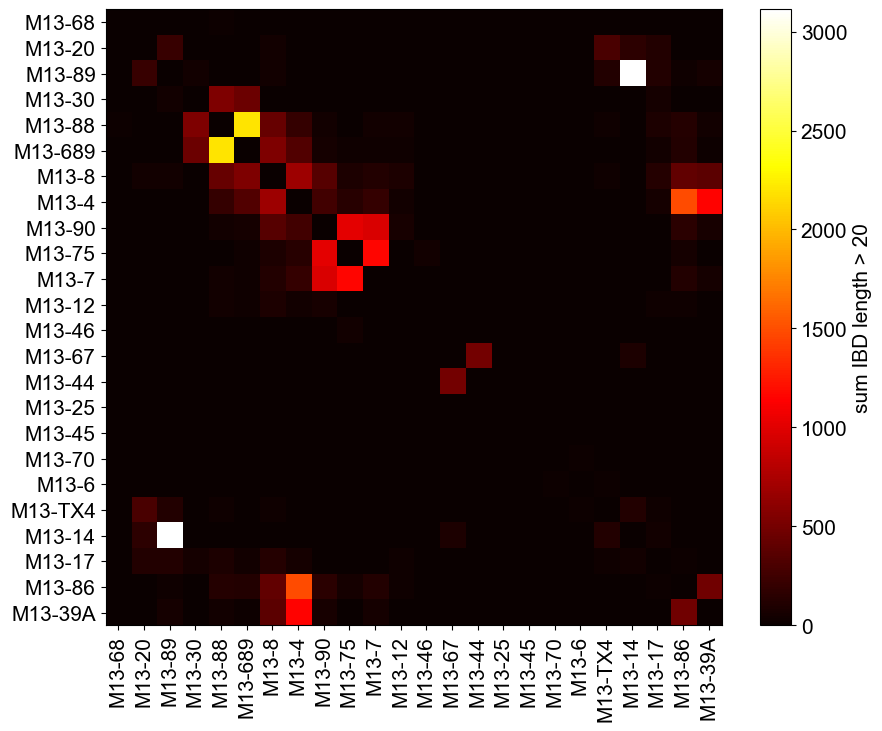

In [7]:
from seg_process import generate_matrix, matrix_simmilarity
np.random.seed(12)

BLG_df = pd.read_csv('../All_ibd_ind.d220.filtered0.15x.csv')
BLG_df = BLG_df[BLG_df['iid1'].str.startswith('BLG_M13') & BLG_df['iid2'].str.startswith('BLG_M13')]
BLG_df['iid1']=BLG_df['iid1'].apply(lambda x:x[4:])
BLG_df['iid2']=BLG_df['iid2'].apply(lambda x:x[4:])

BLG_sex_df = pd.read_csv('../Baligang1.csv',usecols=['Sample','sex','MT haplotype'])
BLG_sex_df.columns = ['iid', 'sex', 'mt']
BLG_sex_df['iid']=BLG_sex_df['iid'].apply(lambda x:x[4:])

BLG_matrix_cl = generate_matrix(BLG_df, BLG_sex_df, order = 'level', keep_sex = True, plot = True, clustering=True)

### Simulation 1
10 generations, outsider rates [0,0.2,0.4,0.6]

In [ ]:
from itertools import product
start = time.time()

orates = [0,0.2,0.4,0.6]
pop_ranges = [(50,100),(100,150),(150,200),(200,300),(300,400),(400,500)]
combs = list(product(orates,pop_ranges))

# tree_rep = 1 ## trial run on laptop
# samp_rep = 1
tree_rep = 1200
samp_rep = 50

similarity_df = np.zeros((samp_rep, tree_rep, len(orates), len(pop_ranges)))
matrix_backup = np.zeros((24, 24, samp_rep, tree_rep, len(orates), len(pop_ranges)))
trees_backup = np.full((tree_rep, len(orates), len(pop_ranges)), '', dtype=np.dtype('U1024')) 
centrality_backup = np.ones((tree_rep, len(orates), len(pop_ranges))) 
max_tree_paths = np.full((len(orates), len(pop_ranges)), '', dtype=np.dtype('U1024')) 
median_tree_paths = np.full((len(orates), len(pop_ranges)), '', dtype=np.dtype('U1024')) 


def run_simulations_statmat_orate_pop(comb):
    return run_simulations_statmat_new(out_folder = './outputs/', tree_rep = tree_rep, samp_rep = samp_rep, male_samp_num = 16,
                                                                              female_samp_num = 8, generations = 10, ref_data = BLG_matrix_cl, 
                                                                              size = comb[1], rule = 'patrilineal',outsider_rate=comb[0], matrix_order='orig',
                                                                              use_mt=False, clustering=True, compensate=False, mean_children = 2)

with mp.Pool(processes=40) as pool:
    i=0
    iter = pool.imap(run_simulations_statmat_orate_pop, combs)
    for (similarity_all,matrix_all, trees_all, max_tree, median_tree, centralities) in iter:
        similarity_df[:,:,i//len(pop_ranges), i%len(pop_ranges)] = similarity_all
        matrix_backup[:,:,:,:,i//len(pop_ranges), i%len(pop_ranges)] = matrix_all
        trees_backup[:,i//len(pop_ranges), i%len(pop_ranges)] = trees_all
        centrality_backup[:,i//len(pop_ranges), i%len(pop_ranges)] = centralities
        max_tree_paths[i//len(pop_ranges), i%len(pop_ranges)] = max_tree
        median_tree_paths[i//len(pop_ranges), i%len(pop_ranges)] = median_tree
        i+= 1

timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
np.save(f'../result_npys/BLG_matrix_similarity_orate_pop_{timestamp}.npy', similarity_df)
np.save(f'../result_npys/BLG_matrix_backup_orate_pop_{timestamp}.npy', matrix_backup)
np.save(f'../result_npys/BLG_tree_names_orate_pop_{timestamp}.npy', trees_backup)
np.save(f'../result_npys/BLG_centralities_new_orate_pop_{timestamp}.npy', centrality_backup)

### Simulation 2
10 generations, outsider rates [0.1,0.3,0.5,0.7]

In [ ]:
from itertools import product
start = time.time()

orates = [0.1,0.3,0.5,0.7]
pop_ranges = [(50,100),(100,150),(150,200),(200,300),(300,400),(400,500)]
combs = list(product(orates,pop_ranges))

tree_rep = 1200
samp_rep = 50
similarity_df = np.zeros((samp_rep, tree_rep, len(orates), len(pop_ranges)))
matrix_backup = np.zeros((24, 24, samp_rep, tree_rep, len(orates), len(pop_ranges)))
trees_backup = np.full((tree_rep, len(orates), len(pop_ranges)), '', dtype=np.dtype('U1024')) 
centrality_backup = np.ones((tree_rep, len(orates), len(pop_ranges))) 
max_tree_paths = np.full((len(orates), len(pop_ranges)), '', dtype=np.dtype('U1024')) 
median_tree_paths = np.full((len(orates), len(pop_ranges)), '', dtype=np.dtype('U1024')) 


def run_simulations_statmat_orate_pop(comb):
    return run_simulations_statmat_new(out_folder = './outputs/', tree_rep = tree_rep, samp_rep = samp_rep, male_samp_num = 16,
                                                                              female_samp_num = 8, generations = 10, ref_data = BLG_matrix_cl, 
                                                                              size = comb[1], rule = 'patrilineal',outsider_rate=comb[0], matrix_order='orig',
                                                                              use_mt=False, clustering=True, compensate=False, mean_children = 2)

with mp.Pool(processes=40) as pool:
    i=0
    iter = pool.imap(run_simulations_statmat_orate_pop, combs)
    for (similarity_all,matrix_all, trees_all, max_tree, median_tree, centralities) in iter:
        similarity_df[:,:,i//len(pop_ranges), i%len(pop_ranges)] = similarity_all
        matrix_backup[:,:,:,:,i//len(pop_ranges), i%len(pop_ranges)] = matrix_all
        trees_backup[:,i//len(pop_ranges), i%len(pop_ranges)] = trees_all
        centrality_backup[:,i//len(pop_ranges), i%len(pop_ranges)] = centralities
        max_tree_paths[i//len(pop_ranges), i%len(pop_ranges)] = max_tree
        median_tree_paths[i//len(pop_ranges), i%len(pop_ranges)] = median_tree
        i+= 1

timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
np.save(f'../result_npys/BLG_matrix_similarity_orate_pop_new_{timestamp}.npy', similarity_df)
np.save(f'../result_npys/BLG_matrix_backup_orate_pop_new_{timestamp}.npy', matrix_backup)
np.save(f'../result_npys/BLG_tree_names_orate_pop_new_{timestamp}.npy', trees_backup)
np.save(f'../result_npys/BLG_centralities_new_orate_pop_new_{timestamp}.npy', centrality_backup)

### Simulation 3
9 generations, outsider rates [0,0.2,0.4,0.6]

In [ ]:
from itertools import product
start = time.time()

orates = [0,0.2,0.4,0.6]
pop_ranges = [(50,100),(100,150),(150,200),(200,300),(300,400),(400,500)]
combs = list(product(orates,pop_ranges))

tree_rep = 1200
samp_rep = 50

similarity_df = np.zeros((samp_rep, tree_rep, len(orates), len(pop_ranges)))
matrix_backup = np.zeros((24, 24, samp_rep, tree_rep, len(orates), len(pop_ranges)))
trees_backup = np.full((tree_rep, len(orates), len(pop_ranges)), '', dtype=np.dtype('U1024')) 
centrality_backup = np.ones((tree_rep, len(orates), len(pop_ranges))) 
max_tree_paths = np.full((len(orates), len(pop_ranges)), '', dtype=np.dtype('U1024')) 
median_tree_paths = np.full((len(orates), len(pop_ranges)), '', dtype=np.dtype('U1024')) 


def run_simulations_statmat_orate_pop(comb):
    return run_simulations_statmat_new(out_folder = './outputs/', tree_rep = tree_rep, samp_rep = samp_rep, male_samp_num = 16,
                                                                              female_samp_num = 8, generations = 9, ref_data = BLG_matrix_cl, 
                                                                              size = comb[1], rule = 'patrilineal',outsider_rate=comb[0], matrix_order='orig',
                                                                              use_mt=False, clustering=True, compensate=False, mean_children = 2)

with mp.Pool(processes=40) as pool:
    i=0
    iter = pool.imap(run_simulations_statmat_orate_pop, combs)
    for (similarity_all,matrix_all, trees_all, max_tree, median_tree, centralities) in iter:
        similarity_df[:,:,i//len(pop_ranges), i%len(pop_ranges)] = similarity_all
        matrix_backup[:,:,:,:,i//len(pop_ranges), i%len(pop_ranges)] = matrix_all
        trees_backup[:,i//len(pop_ranges), i%len(pop_ranges)] = trees_all
        centrality_backup[:,i//len(pop_ranges), i%len(pop_ranges)] = centralities
        max_tree_paths[i//len(pop_ranges), i%len(pop_ranges)] = max_tree
        median_tree_paths[i//len(pop_ranges), i%len(pop_ranges)] = median_tree
        i+= 1

timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
np.save(f'../result_npys/BLG_8gen_matrix_similarity_orate_pop_{timestamp}.npy', similarity_df)
np.save(f'../result_npys/BLG_8gen_matrix_backup_orate_pop_{timestamp}.npy', matrix_backup)
np.save(f'../result_npys/BLG_8gen_tree_names_orate_pop_{timestamp}.npy', trees_backup)
np.save(f'../result_npys/BLG_8gen_centralities_new_orate_pop_{timestamp}.npy', centrality_backup)

### Simulation 4
9 generations, outsider rates [0.1,0.3,0.5,0.7]

In [ ]:
from itertools import product
start = time.time()

orates = [0.1,0.3,0.5,0.7]
pop_ranges = [(50,100),(100,150),(150,200),(200,300),(300,400),(400,500)]
combs = list(product(orates,pop_ranges))

tree_rep = 1200
samp_rep = 50

similarity_df = np.zeros((samp_rep, tree_rep, len(orates), len(pop_ranges)))
matrix_backup = np.zeros((24, 24, samp_rep, tree_rep, len(orates), len(pop_ranges)))
trees_backup = np.full((tree_rep, len(orates), len(pop_ranges)), '', dtype=np.dtype('U1024')) 
centrality_backup = np.ones((tree_rep, len(orates), len(pop_ranges))) 
max_tree_paths = np.full((len(orates), len(pop_ranges)), '', dtype=np.dtype('U1024')) 
median_tree_paths = np.full((len(orates), len(pop_ranges)), '', dtype=np.dtype('U1024')) 


def run_simulations_statmat_orate_pop(comb):
    return run_simulations_statmat_new(out_folder = './outputs/', tree_rep = tree_rep, samp_rep = samp_rep, male_samp_num = 16,
                                                                              female_samp_num = 8, generations = 9, ref_data = BLG_matrix_cl, 
                                                                              size = comb[1], rule = 'patrilineal',outsider_rate=comb[0], matrix_order='orig',
                                                                              use_mt=False, clustering=True, compensate=False, mean_children = 2)

with mp.Pool(processes=40) as pool:
    i=0
    iter = pool.imap(run_simulations_statmat_orate_pop, combs)
    for (similarity_all,matrix_all, trees_all, max_tree, median_tree, centralities) in iter:
        similarity_df[:,:,i//len(pop_ranges), i%len(pop_ranges)] = similarity_all
        matrix_backup[:,:,:,:,i//len(pop_ranges), i%len(pop_ranges)] = matrix_all
        trees_backup[:,i//len(pop_ranges), i%len(pop_ranges)] = trees_all
        centrality_backup[:,i//len(pop_ranges), i%len(pop_ranges)] = centralities
        max_tree_paths[i//len(pop_ranges), i%len(pop_ranges)] = max_tree
        median_tree_paths[i//len(pop_ranges), i%len(pop_ranges)] = median_tree
        i+= 1

timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
np.save(f'../result_npys/BLG_8gen_matrix_similarity_orate_pop_{timestamp}.npy', similarity_df)
np.save(f'../result_npys/BLG_8gen_matrix_backup_orate_pop_{timestamp}.npy', matrix_backup)
np.save(f'../result_npys/BLG_8gen_tree_names_orate_pop_{timestamp}.npy', trees_backup)
np.save(f'../result_npys/BLG_8gen_centralities_new_orate_pop_{timestamp}.npy', centrality_backup)

## Rearrange results for post processing

### Get datasets with uniformly distributed centrality

### Training set



In [8]:
# 1800 pedigrees (each with 50 samples) for each individual number interval

import gc
from post_process_for_simulation import get_data_small, flatten_data_list

np.random.seed(12) # for reproducibility

matrix_paths = sorted([x for x in os.listdir('../result_npys') if 'matrix_backup' in x])
centrality_paths = sorted([x for x in os.listdir('../result_npys') if 'centralities' in x])
tree_paths = sorted([x for x in os.listdir('../result_npys') if 'tree_names' in x])

matrix_lists = []
tree_lists = []
centrality_lists = []

for i in range(len(matrix_paths)):
    matrix_backup = np.load(os.path.join('../result_npys',matrix_paths[i]))
    centrality_backup = np.load(os.path.join('../result_npys',centrality_paths[i]))
    tree_backup = np.load(os.path.join('../result_npys',tree_paths[i]))
    
    if tree_backup.shape[2]==2: # except for "only using (100,150) and (150,200)", which has an independent small backup
        continue
    
    print(tree_backup.shape)
    print(centrality_backup.shape)
    print(matrix_backup.shape)
    
    if tree_backup.shape[0]!=1200: # rearrange mis-concatenated dfs
        tree_backup = np.concatenate((tree_backup[:,:int(tree_backup.shape[1]/2),:],tree_backup[:,int(tree_backup.shape[1]/2):,:]),axis = 0)
    if centrality_backup.shape[0]!=1200:
        centrality_backup = np.concatenate((centrality_backup[:,:int(centrality_backup.shape[1]/2),:],centrality_backup[:,int(centrality_backup.shape[1]/2):,:]),axis = 0)
    if matrix_backup.shape[3]!=1200:
        matrix_backup = np.concatenate((matrix_backup[:,:int(matrix_backup.shape[1]/2),:,:,:,:],matrix_backup[:,int(matrix_backup.shape[1]/2):,:,:,:,:]),axis = 3)

    matrix_lists, tree_lists, centrality_lists = get_data_small(centrality_backup,matrix_backup,tree_backup,
                                                    matrix_lists = matrix_lists, tree_lists = tree_lists, centrality_lists = centrality_lists,
                                                    first_run = (i==0), sample = (i==(len(matrix_paths)-1)))
    
    del matrix_backup
    gc.collect()

flat_matrices, flat_tree, flat_centrality  = flatten_data_list(matrix_lists, tree_lists, centrality_lists)

os.makedirs('../result_npys/use_small_data',exist_ok=True)
np.save('../result_npys/use_small_data/flat_matrices.npy', flat_matrices)
np.save('../result_npys/use_small_data/flat_tree.npy', flat_tree)
np.save('../result_npys/use_small_data/flat_centrality.npy', flat_centrality)#

(1200, 4, 6)
(1200, 4, 6)
(24, 24, 50, 1200, 4, 6)
(0, 0)
((32,), (32,))
(0, 1)
((107,), (107,))
(0, 2)
((174,), (174,))
(0, 3)
((253,), (253,))
(0, 4)
((316,), (316,))
(0, 5)
((290,), (290,))
(0, 6)
((317,), (317,))
(0, 7)
((269,), (269,))
(0, 8)
((256,), (256,))
(0, 9)
((251,), (251,))
(0, 10)
((243,), (243,))
(0, 11)
((233,), (233,))
(0, 12)
((187,), (187,))
(0, 13)
((181,), (181,))
(0, 14)
((188,), (188,))
(0, 15)
((155,), (155,))
(0, 16)
((42,), (42,))
(0, 17)
((1306,), (1306,))
(1, 0)
((123,), (123,))
(1, 1)
((249,), (249,))
(1, 2)
((303,), (303,))
(1, 3)
((362,), (362,))
(1, 4)
((352,), (352,))
(1, 5)
((341,), (341,))
(1, 6)
((328,), (328,))
(1, 7)
((274,), (274,))
(1, 8)
((254,), (254,))
(1, 9)
((214,), (214,))
(1, 10)
((181,), (181,))
(1, 11)
((149,), (149,))
(1, 12)
((162,), (162,))
(1, 13)
((121,), (121,))
(1, 14)
((95,), (95,))
(1, 15)
((59,), (59,))
(1, 16)
((27,), (27,))
(1, 17)
((1206,), (1206,))
(2, 0)
((253,), (253,))
(2, 1)
((378,), (378,))
(2, 2)
((392,), (392,))
(2,

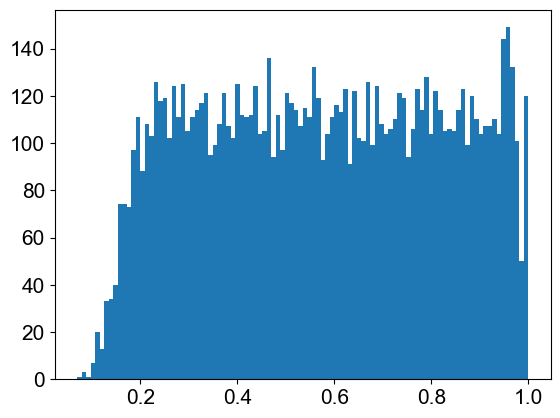

In [9]:
# Sanity check
plt.hist(flat_centrality,100)
plt.show()

### Test set

In [10]:
# basically the same procedure with getting the training set. 
# only 5 samples for each simulated pedigree
# the pedigrees used in training set are avoided.

np.random.seed(12) # for reproducibility

matrix_paths = sorted([x for x in os.listdir('../result_npys') if 'matrix_backup' in x])
centrality_paths = sorted([x for x in os.listdir('../result_npys') if 'centralities' in x])
tree_paths = sorted([x for x in os.listdir('../result_npys') if 'tree_names' in x])

matrix_lists = []
tree_lists = []
centrality_lists = []

for i in range(len(matrix_paths)):
    matrix_backup = np.load(os.path.join('../result_npys',matrix_paths[i]))
    centrality_backup = np.load(os.path.join('../result_npys',centrality_paths[i]))
    tree_backup = np.load(os.path.join('../result_npys',tree_paths[i]))
    
    matrix_backup = matrix_backup[:,:,20:25,:,:,:] # only take 5 samples for each tree
    
    if tree_backup.shape[2]==2: # except for "only using (100,150) and (150,200)", which has an independent small backup
        continue
    
    print(tree_backup.shape)
    print(centrality_backup.shape)
    print(matrix_backup.shape)
    
    if tree_backup.shape[0]!=1200: # rearrange mis-concatenated dfs
        tree_backup = np.concatenate((tree_backup[:,:int(tree_backup.shape[1]/2),:],tree_backup[:,int(tree_backup.shape[1]/2):,:]),axis = 0)
    if centrality_backup.shape[0]!=1200:
        centrality_backup = np.concatenate((centrality_backup[:,:int(centrality_backup.shape[1]/2),:],centrality_backup[:,int(centrality_backup.shape[1]/2):,:]),axis = 0)
    if matrix_backup.shape[3]!=1200:
        matrix_backup = np.concatenate((matrix_backup[:,:int(matrix_backup.shape[1]/2),:,:,:,:],matrix_backup[:,int(matrix_backup.shape[1]/2):,:,:,:,:]),axis = 3)
    
    # take population 100-300
    matrix_backup = matrix_backup[:,:,:,:,:,2:5]
    centrality_backup = centrality_backup[:,:,2:5]
    tree_backup = tree_backup[:,:,2:5]
    
    # set avoid_list = flat_tree prevents training set populations to be sampled again into the test set.
    matrix_lists, tree_lists, centrality_lists = get_data_small(centrality_backup,matrix_backup,tree_backup,
                                                    matrix_lists = matrix_lists, tree_lists = tree_lists, centrality_lists = centrality_lists,
                                                    first_run = (i==0), sample = (i==(len(matrix_paths)-1)), avoid_list = flat_tree, sample_num = 120,
                                                                                 custom_pop_range = [(100,150),(150,200),(200,300)])
    
    del matrix_backup
    gc.collect()

flat_matrices_test, flat_tree_test, flat_centrality_test  = flatten_data_list(matrix_lists, tree_lists, centrality_lists)

os.makedirs('../result_npys/use_small_data',exist_ok=True)
np.save('../result_npys/use_small_data/flat_matrices_test_150_400_2.npy', flat_matrices_test)
np.save('../result_npys/use_small_data/flat_tree_test_150_400_2.npy', flat_tree_test)
np.save('../result_npys/use_small_data/flat_centrality_test_150_400_2.npy', flat_centrality_test)

(1200, 4, 6)
(1200, 4, 6)
(24, 24, 5, 1200, 4, 6)
(0, 0)
((227,), (227,))
(0, 1)
((338,), (338,))
(0, 2)
((360,), (360,))
(0, 3)
((380,), (380,))
(0, 4)
((329,), (329,))
(0, 5)
((308,), (308,))
(0, 6)
((315,), (315,))
(0, 7)
((216,), (216,))
(0, 8)
((160,), (160,))
(0, 9)
((140,), (140,))
(0, 10)
((135,), (135,))
(0, 11)
((122,), (122,))
(0, 12)
((86,), (86,))
(0, 13)
((74,), (74,))
(0, 14)
((41,), (41,))
(0, 15)
((22,), (22,))
(0, 16)
((6,), (6,))
(0, 17)
((1196,), (1196,))
(1, 0)
((406,), (406,))
(1, 1)
((413,), (413,))
(1, 2)
((398,), (398,))
(1, 3)
((372,), (372,))
(1, 4)
((324,), (324,))
(1, 5)
((306,), (306,))
(1, 6)
((256,), (256,))
(1, 7)
((194,), (194,))
(1, 8)
((160,), (160,))
(1, 9)
((117,), (117,))
(1, 10)
((116,), (116,))
(1, 11)
((67,), (67,))
(1, 12)
((69,), (69,))
(1, 13)
((52,), (52,))
(1, 14)
((22,), (22,))
(1, 15)
((6,), (6,))
(1, 16)
((0,), (0,))
(1, 17)
((1190,), (1190,))
(2, 0)
((656,), (656,))
(2, 1)
((450,), (450,))
(2, 2)
((418,), (418,))
(2, 3)
((368,), (368,)

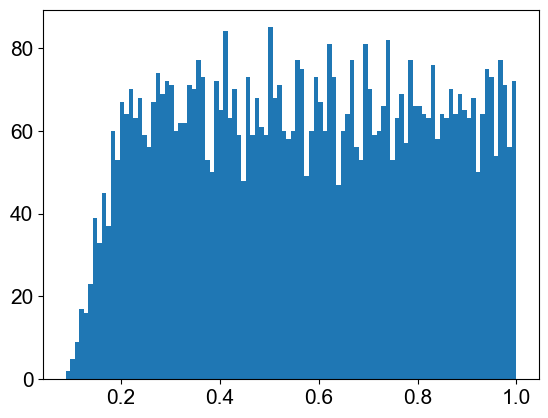

In [11]:
# Sanity check
plt.hist(flat_centrality_test,100)
plt.show()

## Generate artificial test set for individual number estimation

In [19]:
orates = [0]
pop_ranges = [(50,100),(100,150),(150,200),(200,300),(300,400),(400,500)]
tree_rep = 1200
samp_rep = 50

os.makedirs('./arti_outputs', exist_ok=True)

def get_similarities(matrix_backup, ref_matrix = BLG_matrix_cl):
    # calculate similarity df
    similarity_backup = np.zeros((samp_rep, tree_rep, len(orates), len(pop_ranges)))

    for k in range(len(orates)):
        for l in range(len(pop_ranges)):
            print((k,l),end = ',') 
            similarity_df_temp = np.zeros((samp_rep, tree_rep))
            for j in range(tree_rep):
                for i in range(samp_rep):
                    similarity_df_temp[i,j] = matrix_simmilarity(matrix_backup[:,:,i,j,k,l],ref_matrix)
            similarity_backup[:,:,k,l] = similarity_df_temp
                     
    return similarity_backup    

def generate_artificial_data(out_folder = './arti_outputs/', male_samp_num = 35, female_samp_num = 10, 
                    size = (100,150), generations = 7, mean_children = 2, outsider_rate = 0, rule = 'patrilineal', purity = 1, die_rate = 0.2,compensate = False,
                    founder_num = 1, matrix_order = 'orig', clustering = False, restrict_centrality = None, return_matrix = False):
    
    timestamp = datetime.datetime.now().strftime(f"%Y_%m_%d_%H_%M_%S")
    pid = str(random.random())[2:]
    
    the_out_folder = f'{out_folder}{timestamp}_{pid}/'
    os.mkdir(the_out_folder)
    
    basename = f'{timestamp}_{pid}_{generations}gen_{size[1]}size_{rule}_{outsider_rate}out_{purity}pur'
    generate_def(name = basename, rule = rule, size = size, generations = generations, mean_children = mean_children,
                outsider_rate = outsider_rate, purity = purity, die_rate = die_rate, compensate_outsider=compensate, founder_num = founder_num,
                centrality_requirement = restrict_centrality)
    run_pedsim(par_file=f'./defs/'+basename+'.def', output=f"{the_out_folder}{basename}")
    
    fam_info = pd.read_csv(f'{the_out_folder}{basename}-everyone.fam', sep=" ", header=None)
    # print(fam_info)
    fam_info1 = generate_mt_df(fam_info)
    _, individuals, _ = sample_individuals_mf(f"{the_out_folder}{basename}.seg", male_sample_num = male_samp_num,female_sample_num = female_samp_num,
                                                sex_ref = fam_info1, suffix = f'_sample')
    
    for ind, row in fam_info.iterrows():
        if not (row[1] in individuals):
            fam_info.iloc[ind,5] = 0
    fam_info.to_csv(f'{the_out_folder}{basename}-everyone.fam', sep=" ", header=False, index = False)
    
    
    individ_pairs = list(itertools.combinations(individuals, 2))
    new_df = pd.DataFrame([{'iid1': combo[0], 'iid2': combo[1]} for combo in individ_pairs])
    df_test = to_hapsburg_ibd_df(path_segments = f"{the_out_folder}{basename}_sample.seg", n=500)
    
    merged_df = df_test.merge(new_df, on=['iid1', 'iid2'],how = 'right')
    merged_df.fillna(0, inplace=True)
    
    IBD_matrix = generate_matrix(merged_df, fam_info1, mt_ref=None, order = matrix_order, keep_sex = True, plot = False, clustering=clustering)
    
    tree_name = f'{the_out_folder}{basename}-everyone.fam'
    
    os.remove(f"{the_out_folder}{basename}.seg") 
    os.remove(f"{the_out_folder}{basename}_sample.seg") 
    
    return IBD_matrix, tree_name

def Artificial_validation_pop(male_samp_num = 16, female_samp_num = 8, size = (125,150), generations = 10,outsider_rate = 0, rule = 'patrilineal',
                          restrict_centrality = None):
    
    # restrict centrality
    # restrict population to <=300
    
    ref_matrix, _  = generate_artificial_data(male_samp_num = male_samp_num, female_samp_num = female_samp_num, size = size, generations = generations,
                                        outsider_rate = outsider_rate, rule = rule, restrict_centrality = restrict_centrality, return_matrix = True)

    matrix_paths = sorted([x for x in os.listdir('../result_npys') if 'matrix_backup' in x])
    centrality_paths = sorted([x for x in os.listdir('../result_npys') if 'centralities' in x])
    tree_paths = sorted([x for x in os.listdir('../result_npys') if 'tree_names' in x])
    

    for i in range(len(matrix_paths)):
        matrix_backup = np.load(os.path.join('../result_npys',matrix_paths[i]))
        centrality_backup = np.load(os.path.join('../result_npys',centrality_paths[i]))
        tree_backup = np.load(os.path.join('../result_npys',tree_paths[i]))
        
        if tree_backup.shape[2]==2: # full population mode
            continue
        
        if tree_backup.shape[0]!=1200:
            tree_backup = np.concatenate((tree_backup[:,:int(tree_backup.shape[1]/2),:],tree_backup[:,int(tree_backup.shape[1]/2):,:]),axis = 0)
        if centrality_backup.shape[0]!=1200:
            centrality_backup = np.concatenate((centrality_backup[:,:int(centrality_backup.shape[1]/2),:],centrality_backup[:,int(centrality_backup.shape[1]/2):,:]),axis = 0)
        if matrix_backup.shape[3]!=1200:
            matrix_backup = np.concatenate((matrix_backup[:,:int(matrix_backup.shape[1]/2),:,:,:,:],matrix_backup[:,int(matrix_backup.shape[1]/2):,:,:,:,:]),axis = 3)
        
        if i==0:
            similarity_backup1 = get_similarities(matrix_backup, ref_matrix = ref_matrix)
            centrality_backup1 = centrality_backup[:,0,:]
            tree_backup1 = tree_backup[:,0,:]
        else:
            similarity_new = get_similarities(matrix_backup, ref_matrix = ref_matrix)
            centrality_new = centrality_backup[:,0,:]
            tree_new = tree_backup[:,0,:]

            similarity_backup1 = np.concatenate((similarity_backup1,similarity_new), axis = 1)
            centrality_backup1 = np.concatenate((centrality_backup1,centrality_new), axis = 0)
            tree_backup1 = np.concatenate((tree_backup1,tree_new), axis = 0)
        
        del matrix_backup
        gc.collect()
    
    mean_similarity_by_tree = np.mean(similarity_backup1, axis = 0)

    mean_similarities = np.squeeze(np.mean(mean_similarity_by_tree, axis = 0))
    max_similarity_by_tree = np.squeeze(np.max(mean_similarity_by_tree, axis = 0))

    similarity_df_flat = np.sort(mean_similarity_by_tree,axis = 0)
    mean_top50_similarity = np.squeeze(np.mean(similarity_df_flat[-50:,:,:], axis = 0))
    
    similarity_backup_flat = similarity_backup1.reshape(-1, *similarity_backup1.shape[2:])
    similarity_backup_flat = np.sort(similarity_backup_flat,axis = 0)
    mean_top50_sample_similarity = np.squeeze(np.mean(similarity_backup_flat[-50:,:,:], axis = 0))
    
    top_similarity_backup = np.squeeze(similarity_backup_flat[-2400:,:,:])
    similarity_bytree_backup = np.squeeze(similarity_df_flat)
    print(top_similarity_backup.shape)
    print(similarity_bytree_backup.shape)
    
    return mean_similarities, max_similarity_by_tree, mean_top50_similarity, mean_top50_sample_similarity, top_similarity_backup, similarity_bytree_backup
    

### Simulation 1

In [ ]:
start = time.time()

sizes = [(100,125),(125,150),(150,200),(200,250),(250,300),(300,350),(350,400),(400,450),(450,500)]

pop_ranges = [(50,100),(100,150),(150,200),(200,300),(300,400),(400,500)]
pop_ranges_str = [f'{pop}' for pop in pop_ranges]

reps = 200

def validation_by_pop(size):
    test_data_temp = np.zeros((4,reps,6))
    top_similarity_temp = np.zeros((2400,reps,6))
    similarity_bytree_temp = np.zeros((4800,reps,6))
    for i in range(reps):
        mean_similarities, max_similarity_by_tree, mean_top50_similarity, mean_top50_sample_similarity, top_similarity_backup, similarity_bytree_backup  = Artificial_validation_pop(size = size, outsider_rate = 0, rule = 'patrilineal', generations=9)
        test_data_temp[0,i,:] = mean_similarities
        test_data_temp[1,i,:] = max_similarity_by_tree
        test_data_temp[2,i,:] = mean_top50_similarity
        test_data_temp[3,i,:] = mean_top50_sample_similarity
        
        top_similarity_temp[:,i,:] = top_similarity_backup
        similarity_bytree_temp[:,i,:] = similarity_bytree_backup
        
    return test_data_temp, top_similarity_temp, similarity_bytree_temp

test_data = np.zeros((4,reps,len(sizes),6))
top_similarity_data = np.zeros((2400,reps,len(sizes),6))
similarity_bytree_data = np.zeros((4800,reps,len(sizes),6))
with mp.Pool(processes=12) as pool:
    iter = pool.imap(validation_by_pop, sizes)
    i = 0
    for (test_data_temp, top_similarity_temp, similarity_bytree_temp) in iter:
        test_data[:,:,i,:] = test_data_temp
        top_similarity_data[:,:,i,:] = top_similarity_temp
        similarity_bytree_data[:,:,i,:] = similarity_bytree_temp
        i += 1

np.save('../result_npys/test_data_pop_0225_1',test_data)
np.save('../result_npys/top_similarity_data_pop_0225_1',top_similarity_data)
np.save('../result_npys/similarity_bytree_data_pop_0225_1',similarity_bytree_data)

end = time.time()
print(f'Elapsed {end-start} seconds')

### Simulation 2

In [ ]:
start = time.time()

sizes = [(200,250),(250,300),(300,350),(350,400),(400,450),(450,500)]

pop_ranges = [(50,100),(100,150),(150,200),(200,300),(300,400),(400,500)]
pop_ranges_str = [f'{pop}' for pop in pop_ranges]

reps = 200

def validation_by_pop(size):
    test_data_temp = np.zeros((4,reps,6))
    top_similarity_temp = np.zeros((2400,reps,6))
    similarity_bytree_temp = np.zeros((4800,reps,6))
    for i in range(reps):
        mean_similarities, max_similarity_by_tree, mean_top50_similarity, mean_top50_sample_similarity, top_similarity_backup, similarity_bytree_backup  = Artificial_validation_pop(size = size, outsider_rate = 0, rule = 'patrilineal', generations=9)
        test_data_temp[0,i,:] = mean_similarities
        test_data_temp[1,i,:] = max_similarity_by_tree
        test_data_temp[2,i,:] = mean_top50_similarity
        test_data_temp[3,i,:] = mean_top50_sample_similarity
        
        top_similarity_temp[:,i,:] = top_similarity_backup
        similarity_bytree_temp[:,i,:] = similarity_bytree_backup
        
    return test_data_temp, top_similarity_temp, similarity_bytree_temp

test_data = np.zeros((4,reps,len(sizes),6))
top_similarity_data = np.zeros((2400,reps,len(sizes),6))
similarity_bytree_data = np.zeros((4800,reps,len(sizes),6))
with mp.Pool(processes=12) as pool:
    iter = pool.imap(validation_by_pop, sizes)
    i = 0
    for (test_data_temp, top_similarity_temp, similarity_bytree_temp) in iter:
        test_data[:,:,i,:] = test_data_temp
        top_similarity_data[:,:,i,:] = top_similarity_temp
        similarity_bytree_data[:,:,i,:] = similarity_bytree_temp
        i += 1

np.save('../result_npys/test_data_pop_0225_1_part2',test_data)
np.save('../result_npys/top_similarity_data_pop_0225_1_part2',top_similarity_data)
np.save('../result_npys/similarity_bytree_data_pop_0225_1_part2',similarity_bytree_data)

end = time.time()
print(f'Elapsed {end-start} seconds')

### Simulation 3

In [ ]:
start = time.time()

sizes = [(100,125),(125,150),(150,200)]

pop_ranges = [(50,100),(100,150),(150,200),(200,300),(300,400),(400,500)]
pop_ranges_str = [f'{pop}' for pop in pop_ranges]

reps = 200

def validation_by_pop(size):
    test_data_temp = np.zeros((4,reps,6))
    top_similarity_temp = np.zeros((2400,reps,6))
    similarity_bytree_temp = np.zeros((4800,reps,6))
    for i in range(reps):
        mean_similarities, max_similarity_by_tree, mean_top50_similarity, mean_top50_sample_similarity, top_similarity_backup, similarity_bytree_backup  = Artificial_validation_pop(size = size, outsider_rate = 0, rule = 'patrilineal', generations=9)
        test_data_temp[0,i,:] = mean_similarities
        test_data_temp[1,i,:] = max_similarity_by_tree
        test_data_temp[2,i,:] = mean_top50_similarity
        test_data_temp[3,i,:] = mean_top50_sample_similarity
        
        top_similarity_temp[:,i,:] = top_similarity_backup
        similarity_bytree_temp[:,i,:] = similarity_bytree_backup
        
    return test_data_temp, top_similarity_temp, similarity_bytree_temp

test_data = np.zeros((4,reps,len(sizes),6))
top_similarity_data = np.zeros((2400,reps,len(sizes),6))
similarity_bytree_data = np.zeros((4800,reps,len(sizes),6))
with mp.Pool(processes=12) as pool:
    iter = pool.imap(validation_by_pop, sizes)
    i = 0
    for (test_data_temp, top_similarity_temp, similarity_bytree_temp) in iter:
        test_data[:,:,i,:] = test_data_temp
        top_similarity_data[:,:,i,:] = top_similarity_temp
        similarity_bytree_data[:,:,i,:] = similarity_bytree_temp
        i += 1

np.save('../result_npys/test_data_pop_0226_1_part1',test_data)
np.save('../result_npys/top_similarity_data_pop_0226_1_part1',top_similarity_data)
np.save('../result_npys/similarity_bytree_data_pop_0226_1_part1',similarity_bytree_data)

end = time.time()
print(f'Elapsed {end-start} seconds')

### Simulation 4

In [ ]:
start = time.time()

sizes = [(200,250),(250,300),(300,350),(350,400),(400,450),(450,500)]

pop_ranges = [(50,100),(100,150),(150,200),(200,300),(300,400),(400,500)]
pop_ranges_str = [f'{pop}' for pop in pop_ranges]

reps = 200

def validation_by_pop(size):
    test_data_temp = np.zeros((4,reps,6))
    top_similarity_temp = np.zeros((2400,reps,6))
    similarity_bytree_temp = np.zeros((4800,reps,6))
    for i in range(reps):
        mean_similarities, max_similarity_by_tree, mean_top50_similarity, mean_top50_sample_similarity, top_similarity_backup, similarity_bytree_backup  = Artificial_validation_pop(size = size, outsider_rate = 0, rule = 'patrilineal', generations=9)
        test_data_temp[0,i,:] = mean_similarities
        test_data_temp[1,i,:] = max_similarity_by_tree
        test_data_temp[2,i,:] = mean_top50_similarity
        test_data_temp[3,i,:] = mean_top50_sample_similarity
        
        top_similarity_temp[:,i,:] = top_similarity_backup
        similarity_bytree_temp[:,i,:] = similarity_bytree_backup
        
    return test_data_temp, top_similarity_temp, similarity_bytree_temp

test_data = np.zeros((4,reps,len(sizes),6))
top_similarity_data = np.zeros((2400,reps,len(sizes),6))
similarity_bytree_data = np.zeros((4800,reps,len(sizes),6))
with mp.Pool(processes=12) as pool:
    iter = pool.imap(validation_by_pop, sizes)
    i = 0
    for (test_data_temp, top_similarity_temp, similarity_bytree_temp) in iter:
        test_data[:,:,i,:] = test_data_temp
        top_similarity_data[:,:,i,:] = top_similarity_temp
        similarity_bytree_data[:,:,i,:] = similarity_bytree_temp
        i += 1

np.save('../result_npys/test_data_pop_0226_1_part2',test_data)
np.save('../result_npys/top_similarity_data_pop_0226_1_part2',top_similarity_data)
np.save('../result_npys/similarity_bytree_data_pop_0226_1_part2',similarity_bytree_data)

end = time.time()
print(f'Elapsed {end-start} seconds')